# P5: Identify Fraud from Enron Email

*by Laima Stinskaite*

## Introduction

In 2000, Enron was one of the largest companies in the United States. By 2002, it had collapsed into bankruptcy due to widespread corporate fraud. In the resulting Federal investigation, there was a significant amount of typically confidential information entered into public record, including tens of thousands of emails and detailed financial data for top executives.

In this document we try to identify POIs (person of interest) by using machine learning techniques. POI was who indicted, reached a settlement or plea deal with the government, or testified in exchange for prosecution immunity. 

So the goal of this project is to train and tune a machine learning algorithm that can predict which employees are POIs using Enron financial and email data.

## Data Exploration

The Enron email and financial data was combined into a dictionary, where each key-value pair in the dictionary corresponds to one person. The dictionary key is the person's name, and the value is another dictionary, which contains the names of all the features and their values for that person. The features in the data fall into three major types, namely financial features, email features and POI labels.

__financial features__: ['salary', 'deferral_payments', 'total_payments', 'loan_advances', 'bonus', 'restricted_stock_deferred', 'deferred_income', 'total_stock_value', 'expenses', 'exercised_stock_options', 'other', 'long_term_incentive', 'restricted_stock', 'director_fees'] (all units are in US dollars)

__email features__: ['to_messages', 'email_address', 'from_poi_to_this_person', 'from_messages', 'from_this_person_to_poi', 'shared_receipt_with_poi'] (units are generally number of emails messages; notable exception is ‘email_address’, which is a text string)

__POI label__: [‘poi’] (boolean, represented as integer)

In [43]:
### Import all necessary in this project libraries
import sys
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
sys.path.append("../tools/")
from feature_format import featureFormat, targetFeatureSplit
from time import time
from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.grid_search import GridSearchCV
from tester import test_classifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [44]:
### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

After we load our data we will investigate it a little bit. We are interested in the following aspects:
- number of rows (total number of people) in the dataset
- names of all people in the dataset
- number of features for every person
- list of features for person
- number of POIs
- names of POIs

In [45]:
### Number of rows in the dataset
print 'Total number of people in our dataset: %d' % len(data_dict)
print ''

### Names of all people from the dataset
print data_dict.keys()
print ''

### Number of features for person
print 'Number of features for person: %d' % len(data_dict["METTS MARK"].keys())
print ''

### List of features for person
print data_dict["METTS MARK"].keys()
print ''

### Number of POIs
count = 0
pois = []
for person in data_dict:
    if data_dict[person]['poi'] == 1:
        count = count + 1
        pois.append(person)
print 'Number of POIs: %d' % count
print ''

### Names of POIs
print pois

Total number of people in our dataset: 146

['METTS MARK', 'BAXTER JOHN C', 'ELLIOTT STEVEN', 'CORDES WILLIAM R', 'HANNON KEVIN P', 'MORDAUNT KRISTINA M', 'MEYER ROCKFORD G', 'MCMAHON JEFFREY', 'HORTON STANLEY C', 'PIPER GREGORY F', 'HUMPHREY GENE E', 'UMANOFF ADAM S', 'BLACHMAN JEREMY M', 'SUNDE MARTIN', 'GIBBS DANA R', 'LOWRY CHARLES P', 'COLWELL WESLEY', 'MULLER MARK S', 'JACKSON CHARLENE R', 'WESTFAHL RICHARD K', 'WALTERS GARETH W', 'WALLS JR ROBERT H', 'KITCHEN LOUISE', 'CHAN RONNIE', 'BELFER ROBERT', 'SHANKMAN JEFFREY A', 'WODRASKA JOHN', 'BERGSIEKER RICHARD P', 'URQUHART JOHN A', 'BIBI PHILIPPE A', 'RIEKER PAULA H', 'WHALEY DAVID A', 'BECK SALLY W', 'HAUG DAVID L', 'ECHOLS JOHN B', 'MENDELSOHN JOHN', 'HICKERSON GARY J', 'CLINE KENNETH W', 'LEWIS RICHARD', 'HAYES ROBERT E', 'MCCARTY DANNY J', 'KOPPER MICHAEL J', 'LEFF DANIEL P', 'LAVORATO JOHN J', 'BERBERIAN DAVID', 'DETMERING TIMOTHY J', 'WAKEHAM JOHN', 'POWERS WILLIAM', 'GOLD JOSEPH', 'BANNANTINE JAMES M', 'DUNCAN JOHN H', 'SHA

Before we begin selection of features, let's first check our dataset for outliers.

## Data cleaning

In [46]:
### Show first 5 persons from dataset
first_persons = {k: data_dict[k] for k in data_dict.keys()[:5]}
print first_persons

{'METTS MARK': {'salary': 365788, 'to_messages': 807, 'deferral_payments': 'NaN', 'total_payments': 1061827, 'exercised_stock_options': 'NaN', 'bonus': 600000, 'restricted_stock': 585062, 'shared_receipt_with_poi': 702, 'restricted_stock_deferred': 'NaN', 'total_stock_value': 585062, 'expenses': 94299, 'loan_advances': 'NaN', 'from_messages': 29, 'other': 1740, 'from_this_person_to_poi': 1, 'poi': False, 'director_fees': 'NaN', 'deferred_income': 'NaN', 'long_term_incentive': 'NaN', 'email_address': 'mark.metts@enron.com', 'from_poi_to_this_person': 38}, 'BAXTER JOHN C': {'salary': 267102, 'to_messages': 'NaN', 'deferral_payments': 1295738, 'total_payments': 5634343, 'exercised_stock_options': 6680544, 'bonus': 1200000, 'restricted_stock': 3942714, 'shared_receipt_with_poi': 'NaN', 'restricted_stock_deferred': 'NaN', 'total_stock_value': 10623258, 'expenses': 11200, 'loan_advances': 'NaN', 'from_messages': 'NaN', 'other': 2660303, 'from_this_person_to_poi': 'NaN', 'poi': False, 'direct

As we see, practically every person has NaN values. In this case outlier can be if person has NaN values for every feature. Let's check that our data doesn't consist of such people:

In [47]:
### Check if our dataset consists of people with all NaN features
for person in data_dict:
    if data_dict[person]['to_messages'] == 'NaN' and \
        data_dict[person]['shared_receipt_with_poi'] == 'NaN' and \
        data_dict[person]['from_messages'] == 'NaN' and \
        data_dict[person]['from_this_person_to_poi'] == 'NaN' and \
        data_dict[person]['email_address'] == 'NaN' and \
        data_dict[person]['from_poi_to_this_person'] == 'NaN' and \
        data_dict[person]['salary'] == 'NaN' and \
        data_dict[person]['deferral_payments'] == 'NaN' and \
        data_dict[person]['total_payments'] == 'NaN' and \
        data_dict[person]['exercised_stock_options'] == 'NaN' and \
        data_dict[person]['bonus'] == 'NaN' and \
        data_dict[person]['restricted_stock'] == 'NaN' and \
        data_dict[person]['restricted_stock_deferred'] == 'NaN' and \
        data_dict[person]['total_stock_value'] == 'NaN' and \
        data_dict[person]['expenses'] == 'NaN' and \
        data_dict[person]['loan_advances'] == 'NaN' and \
        data_dict[person]['other'] == 'NaN' and \
        data_dict[person]['director_fees'] == 'NaN' and \
        data_dict[person]['deferred_income'] == 'NaN' and \
        data_dict[person]['long_term_incentive'] == 'NaN':
        print person

LOCKHART EUGENE E


Yes, as we see, one person from our dataset has NaN values for every feature. It is definitely an outlier and we should remove it.

Also, from course lesson we found 'TOTAL' key as an outlier. Let's take a look at relationship between salary and bonus one more time, to be sure that we have an outlier there:

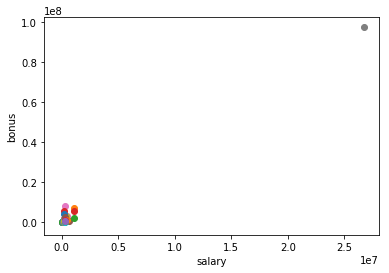

In [48]:
### Create a plot for salary and bonus features
features = ["salary", "bonus"]
data = featureFormat(data_dict, features)

for item in data:
    salary = item[0]
    bonus = item[1]
    plt.scatter(salary, bonus)

plt.xlabel("salary")
plt.ylabel("bonus")
plt.show()

Yes, 'TOTAL' is an outlier and we should remove it from our dataset too.

In [49]:
### Remove LOCKHART EUGENE E from our dataset
data_dict.pop('LOCKHART EUGENE E', 0)

### Remove TOTAL from our dataset
data_dict.pop('TOTAL', 0)

### Show number of people in the dataset
print 'Total number of people in our dataset: %d' % len(data_dict)

Total number of people in our dataset: 144


Every feature beside 'email_address' consists of numbers. 'email_address' feature consists of string value. As we know, we will perform different machine learning technics (work with numbers) further, so we should remove this feature from our features_list.

In [50]:
### Remove 'email_address' column
for key in data_dict:
    features_dict = data_dict[key]
    features_dict.pop('email_address', 0)

### Show number of features
print 'Number of features for person: %d' % len(data_dict["METTS MARK"].keys())

Number of features for person: 20


Now, let's change all NaN values to 0:

In [10]:
### Change missing data by setting their value to 0
for key in data_dict:
    features_dict = data_dict[key]
    for feature in features_dict:
        if features_dict[feature] == 'NaN':
            features_dict[feature] = 0

### Show first 5 persons from dataset
first_persons = {k: data_dict[k] for k in data_dict.keys()[:5]}
print first_persons

{'METTS MARK': {'salary': 365788, 'to_messages': 807, 'deferral_payments': 0, 'total_payments': 1061827, 'exercised_stock_options': 0, 'bonus': 600000, 'restricted_stock': 585062, 'shared_receipt_with_poi': 702, 'restricted_stock_deferred': 0, 'total_stock_value': 585062, 'expenses': 94299, 'loan_advances': 0, 'from_messages': 29, 'other': 1740, 'from_this_person_to_poi': 1, 'poi': False, 'director_fees': 0, 'deferred_income': 0, 'long_term_incentive': 0, 'from_poi_to_this_person': 38}, 'BAXTER JOHN C': {'salary': 267102, 'to_messages': 0, 'deferral_payments': 1295738, 'total_payments': 5634343, 'exercised_stock_options': 6680544, 'bonus': 1200000, 'restricted_stock': 3942714, 'shared_receipt_with_poi': 0, 'restricted_stock_deferred': 0, 'total_stock_value': 10623258, 'expenses': 11200, 'loan_advances': 0, 'from_messages': 0, 'other': 2660303, 'from_this_person_to_poi': 0, 'poi': False, 'director_fees': 0, 'deferred_income': -1386055, 'long_term_incentive': 1586055, 'from_poi_to_this_p

After we cleaned our dataset, we are ready to begin the feature creation and selection processes.

## Feature Selection

### Performance of all original features from dataset

The next step in our analysis will be selecting features for machine learning algorithms. 
First, let's take a look at accuracy score of all features list using DecisionTreeClassifier:

In [11]:
def testClassifier(classifier):
    """
    Function uses classifier and prints all its metrics
    Arguments: classifier
    """
    clf = classifier
    t0 = time()
    clf = clf.fit(features_train, labels_train)
    print 'Training time: ', t0
    t1 = time()
    pred = clf.predict(features_test)
    print 'Testing time: ', t1

    ### metrics
    features_accuracy = accuracy_score(labels_test, pred)
    features_precision_score = precision_score(labels_test, pred)
    features_recall_score = recall_score(labels_test, pred)
    features_f1_score = f1_score(labels_test, pred)

    print 'Accuracy: ', features_accuracy
    print 'Precision: ', features_precision_score
    print 'Recall: ', features_recall_score
    print 'F1 score:', features_f1_score

In [12]:
### List of original features
features_list_original = ['poi', 'salary', 'to_messages', 'deferral_payments', 'total_payments', \
                'exercised_stock_options', 'bonus', 'restricted_stock', 'shared_receipt_with_poi', \
                'restricted_stock_deferred', 'total_stock_value', 'expenses', 'loan_advances', \
                'from_messages', 'other', 'from_this_person_to_poi', 'director_fees', \
                'deferred_income', 'long_term_incentive', 'from_poi_to_this_person']

### Store to my_dataset for easy export below.
my_dataset = data_dict

### Extract features and labels from dataset for local testing
data = featureFormat(my_dataset, features_list_original, sort_keys = True)
labels, features = targetFeatureSplit(data)

### Split data into training and testing datasets
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size = 0.3, random_state = 42)

### Use DecisionTreeClassifier for all original features
print 'Decision Tree Classifier for original features list:'
testClassifier(DecisionTreeClassifier(random_state=42))

Decision Tree Classifier for original features list:
Training time:  1494759539.21
Testing time:  1494759539.21
Accuracy:  0.840909090909
Precision:  0.25
Recall:  0.2
F1 score: 0.222222222222


### New feature creation

Scaling the features is important to many machine learning algorithms because "since the range of values of raw data varies widely, in some machine learning algorithms, objective functions will not work properly without normalization". Also "the gradient descent converges much faster with feature scaling than without it". (https://en.wikipedia.org/wiki/Feature_scaling)

Now let's take a look at 'to_messages', 'from_poi_to_this_person', 'from_messages', 'from_this_person_to_poi' features. They are all absolute statistics and not good enough to make comparison of the person's emails with POIs.

Let's create 2 additional features for our features list:
- ratio_to_poi (the ratio of emails to POIs to all emails sent)
- ratio_from_poi (the ratio of emails from POIs to all emails received)

We included these features in the dataset because they are relative measurements and they normalize emails data across the rest of the employees.

In [13]:
def computeRatio(poi_messages, all_messages):
    """
    Function computes the ratio of messages sent and received from a POI
    Arguments: poi_messages, all_messages
    Return: ratio of arguments
    """
    if all_messages != 0:
        ratio = float(poi_messages) / float(all_messages)
    else:
        ratio = 0
    return ratio

### Create 2 new features: "ratio_to_poi" and "ratio_from_poi"
for key in my_dataset:
    features_dict = my_dataset[key]
    ratio_to_poi = computeRatio(features_dict["from_this_person_to_poi"], features_dict["from_messages"])
    features_dict["ratio_to_poi"] = ratio_to_poi
    ratio_from_poi = computeRatio(features_dict["from_poi_to_this_person"], features_dict["to_messages"])
    features_dict["ratio_from_poi"] = ratio_from_poi
    
print 'Number of features: ', len(features_dict)

Number of features:  22


Let's check what performance will be after we added new features to our dataset:

In [14]:
### List of original features + new features
features_list_plus_new = ['poi', 'salary', 'to_messages', 'deferral_payments', 'total_payments', \
                'exercised_stock_options', 'bonus', 'restricted_stock', 'shared_receipt_with_poi', \
                'restricted_stock_deferred', 'total_stock_value', 'expenses', 'loan_advances', \
                'from_messages', 'other', 'from_this_person_to_poi', 'director_fees', \
                'deferred_income', 'long_term_incentive', 'from_poi_to_this_person', \
                'ratio_to_poi', 'ratio_from_poi']

### Extract features and labels from dataset for local testing
data = featureFormat(my_dataset, features_list_plus_new, sort_keys = True)
labels, features = targetFeatureSplit(data)

### Split data into training and testing datasets
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size = 0.3, random_state = 42)

### Use DecisionTreeClassifier for all original features and new features
print 'Decision Tree Classifier for all original features and new features:'
testClassifier(DecisionTreeClassifier(random_state=42))

Decision Tree Classifier for all original features and new features:
Training time:  1494759591.33
Testing time:  1494759591.33
Accuracy:  0.818181818182
Precision:  0.2
Recall:  0.2
F1 score: 0.2


As we see precision after adding new features became lower (0.2) than before adding them (0.25), so we won't use these features in our analysis.

### Feature selection using SelectKBest

Now let's compare features scores using SelectKBest method with k = 'all'. We will use SelectKBest method with default value f-classif for score_func parameter.  I decided not to use chi2 scoring because there are many negative values in our dataset.

In [82]:
### Show features scores using SelectKBest
slc = SelectKBest(k='all')
slc = slc.fit(features, labels)
scores = slc.scores_
    
print 'Features scores: ', sorted(scores, reverse = True)

Features scores:  [inf, 772.43341185601332, 556.77730806873853, 287.2664203370756, 253.70964054494021, 73.48004838395714, 52.561787970591261, 43.569827232179648, 24.176713973334053, 3.6436367678039865, 3.3799033334556121, 3.0881544960334821, 2.7152382606791057, 2.4765688698248112, 1.712424636015998, 1.3179737674187317, 0.12814399385851574, 0.017226936204361963]


As we see above, features scores drop off after 9th feature, so k = 9 features were chosen for further analysis.

In [83]:
### List of original features beside 'poi'
features_list_without_poi = ['salary', 'to_messages', 'deferral_payments', 'total_payments', \
                'exercised_stock_options', 'bonus', 'restricted_stock', 'shared_receipt_with_poi', \
                'restricted_stock_deferred', 'total_stock_value', 'expenses', 'loan_advances', \
                'from_messages', 'other', 'from_this_person_to_poi', 'director_fees', \
                'deferred_income', 'long_term_incentive', 'from_poi_to_this_person']

### Extract features and labels from dataset for local testing
data = featureFormat(my_dataset, features_list_without_poi, sort_keys = True)
labels, features = targetFeatureSplit(data)

### Use SelectKBest classifier for selection of 9 best features from our dataset
slc = SelectKBest(k=9)
slc = slc.fit(features, labels)
features_list = [features_list_without_poi[i] for i in slc.get_support(indices=True)]

### Insert 'poi' to the best_features list
features_list.insert(0, 'poi') 

print 'Best features using SelectKBest: ', features_list

Best features using SelectKBest:  ['poi', 'deferral_payments', 'exercised_stock_options', 'expenses', 'loan_advances', 'from_messages', 'other', 'director_fees', 'deferred_income', 'long_term_incentive']


In [17]:
### Extract features and labels from dataset for local testing
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

### Split data into training and testing datasets
features_train, features_test, labels_train, labels_test = \
    train_test_split(features, labels, test_size=0.3, random_state=42)
    
### Use DecisionTreeClassifier for best 9 features and 'poi'
print 'Decision Tree Classifier for best 9 features and "poi":'
testClassifier(DecisionTreeClassifier(random_state=42))

Decision Tree Classifier for best 9 features and "poi":
Training time:  1494759642.51
Testing time:  1494759642.51
Accuracy:  0.860465116279
Precision:  0.5
Recall:  0.5
F1 score: 0.5


As we see that our both precision and recall scores became equal to 0.5. It is totally improvement than if we will use all features from our dataset, so we will be using the following features which were selected using SelectKBest method:
- poi
- deferral_payments
- exercised_stock_options
- expenses
- loan_advances
- from_messages
- other
- director_fees
- deferred_income
- long_term_incentive

## Algorithm Selection and Tunning

### Algorithm Selection

I chose Adaboost algorithm as a final one. I also evaluated Random Forest and K-Nearest Neighbors algorithms. I decided to choose Adaboost classifier because of its not bad precision and recall scores (0.5 each), and 2 others algorithms to tune using GridSearchCV (they had bad recall scores ~ 1.67). After the algorithm parameter tuning stage was completed the Random Forest and K-Nearest Neighbors classifiers didn't show any improvements in scores. So as a result Adaboost became the winner in this game. When the Adaboost classifier was evaluated with the provided tester.py script it obtained the following scores (accuracy: 0.86067, precision: 0.47273, recall: 0.39000).


#### Adaboost

In [18]:
### Adaboost
print 'Adaboost Classifier:'
testClassifier(AdaBoostClassifier(random_state=42))

Adaboost Classifier:
Training time:  1494759662.22
Testing time:  1494759662.3
Accuracy:  0.860465116279
Precision:  0.5
Recall:  0.5
F1 score: 0.5


#### Random Forest

In [19]:
### Random Forest
print 'Random Forest Classifier:'
testClassifier(RandomForestClassifier(random_state=42))

Random Forest Classifier:
Training time:  1494759677.62
Testing time:  1494759677.65
Accuracy:  0.883720930233
Precision:  1.0
Recall:  0.166666666667
F1 score: 0.285714285714


#### K-Nearest Neighbors

In [20]:
### K-Nearest Neighbors
print 'K-Nearest Neighbors Classifier:'
testClassifier(KNeighborsClassifier())

K-Nearest Neighbors Classifier:
Training time:  1494759693.13
Testing time:  1494759693.13
Accuracy:  0.860465116279
Precision:  0.5
Recall:  0.166666666667
F1 score: 0.25


### Tuning of algorithms

The parameters of machine learning algorithms can have a lot of influence on the algorithms performance on a given metric. An incorrectly tuned algorithm can give poor performance on the training set or overfitting. To tune the parameters of the Random Forest and K-Nearest Neighbors classifiers I used a cross validated grid search. Different sets of parameters for each classifier were tried:
- splitting criterion ('gini' or 'entropy'), number of estimators (1 and 10) and methods for finding max number of features ('auto', 'sqrt', 'log2') (for Random Forest classifier) 
- number of neighbors (1 and 5), weights ('uniform', 'distance') and algorithm ('auto', 'ball_tree', 'kd_tree', 'brute') (for K-Nearest Neighbors classifier).

The best combination of features and parameters per classifier is chosen to predict the POIs using the testing set.
In comparison with the first estimation of the classifiers it can be seen that both Random Forest and K-Nearest Neighbors classifiers didn't improve their scores at all. That's why we won't select them for further analysis.

#### Random Forest

In [21]:
### Random Forest using GridSearchCV
print 'Random Forest using GridSearchCV:'
param_grid = {"n_estimators": [1, 10],
              "criterion": ('gini', 'entropy'),
              "max_features": ('auto', 'sqrt', 'log2'),
              "random_state": [42]}

testClassifier(GridSearchCV(RandomForestClassifier(), param_grid))

Random Forest using GridSearchCV:
Training time:  1494759745.13
Testing time:  1494759745.73
Accuracy:  0.883720930233
Precision:  1.0
Recall:  0.166666666667
F1 score: 0.285714285714


#### K-Nearest Neighbors without Scaling

In [22]:
### K-Nearest Neighbors using GridSearchCV
print 'K-Nearest Neighbors using GridSearchCV:'
param_grid = {"n_neighbors": [1, 5],
              "weights": ('uniform', 'distance'),
              "algorithm": ('auto', 'ball_tree', 'kd_tree', 'brute')}

testClassifier(GridSearchCV(KNeighborsClassifier(), param_grid))

K-Nearest Neighbors using GridSearchCV:
Training time:  1494759764.23
Testing time:  1494759764.36
Accuracy:  0.860465116279
Precision:  0.5
Recall:  0.166666666667
F1 score: 0.25


#### K-Nearest Neighbors with Scaling

In [26]:
### K-Nearest Neighbors using GridSearchCV and StandardScaler
print 'K-Nearest Neighbors using GridSearchCV and StandardScaler:'
knn = KNeighborsClassifier()
estimators = [('scale', StandardScaler()), ('knn', knn)]
pipeline = Pipeline(estimators)
parameters = {'knn__n_neighbors': [1, 5],
              'knn__weights': ('uniform', 'distance'),
              'knn__algorithm': ('auto', 'ball_tree', 'kd_tree', 'brute')}

testClassifier(GridSearchCV(pipeline, parameters))

K-Nearest Neighbors using GridSearchCV and StandardScaler:
Training time:  1494768120.34
Testing time:  1494768120.55
Accuracy:  0.860465116279
Precision:  0.5
Recall:  0.166666666667
F1 score: 0.25


As we see, there is no difference between precision and recall scores when we tuned K-Nearest Neighbors classifier with and without features scaling.

### Selected Algorithm

In [23]:
### Adaboost
print 'Adaboost Classifier:'
testClassifier(AdaBoostClassifier(random_state=42))

Adaboost Classifier:
Training time:  1494759780.53
Testing time:  1494759780.62
Accuracy:  0.860465116279
Precision:  0.5
Recall:  0.5
F1 score: 0.5


## Validation

Validation is the testing of a machine learning algorithm by applying it to data that was not visible during training. The purpose of this is to get an estimate of the algorithms performance. A classic mistake maybe that the model fits the training data very well with low error, but performs badly on not visible test data. This can lead to an over-estimate of the algorithms ability to generalize. I validated my analysis by using a StratifiedShuffleSplit cross validation approach (was used from given tester.py script) because the dataset is kind of skew. The data set is randomly split into training and test sets while preserving the proportions of true and false labels from the original data set.

In [142]:
### run test_classifier function from tester.py file
test_classifier(clf, my_dataset, features_list)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=42)
	Accuracy: 0.86067	Precision: 0.47273	Recall: 0.39000	F1: 0.42740	F2: 0.40415
	Total predictions: 15000	True positives:  780	False positives:  870	False negatives: 1220	True negatives: 12130



## Evaluation Metrics


The accuracy score tells us that on average 86% of the examples in the test were classified correctly by final classifier Adaboost. But this is not the most appropriate metric for this project because there are too many non-POIs in the dataset, and therefore in the testing set. That's why the precision score and recall score were chosen as a better scores for our dataset. 

**Precision** is the ratio of true positive observations among all the population that are predicted as POI (% of correct positive predictions).

**Recall** is the ratio of true positive observations among all the population that are POI (% of caught positive cases).

We can see Adaboost has best precision score = 0.47 and recall score = 0.39. It means that all persons predicted as POI by Adaboost, 47% are true POIs, and 39% of true POIs are caught. Overall, the precision score is better than the recall score meaning that whenever a POI gets flagged in the test set, we can be sure that it is a real POI and not a false one.

## Conclusion

The goal of this project was to train and tune a machine learning algorithm that can predict which employees are POIs using Enron financial and email data. First, we investigated given to us dataset; then we removed outliers, not numeric features and changed NaN values to 0; after that we created new features and selected 9 best of them using SelectKBest method; finally, we used AdaBoost, Random Forest and K-Nearest Neighbors classifiers to predict POI (we tuned Random Forest and K-Nearest Neighbors classifiers to receive better precision and recall scores). Cross-validation showed that Adaboost was more accurate in predicting POI, giving the best precision and recall scores of 0.47 and 0.39 respectively (both over 0.3 as required). It seems that these metrics are not good enough, however the results are good enough considering that the dataset contained very few observations of POIs.